<a href="https://colab.research.google.com/github/tasmimjoti/Computer-Vision/blob/main/A_Regression_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ML Challenge Task

The task is to fit a model to the provided data as closely as possible.

There are 2 datasets provided, a train and a validation set.
Train a model on the train data, and measure its performance on the validation data. The final 'Y' column is the target variable.

For the model training, use either PyTorch or Keras (any version).
For your model, use a standard type of neural net.

Measure its performance using the MAE (mean absolute error).
A reasonably good perforance would be *MAE < 0.006*.

Put your solution in a notebook in a repo in a Github account of your own (if you dont have an account you'll have to create own), and provide us a link to the repo. In your notebook show clearly the MAE you attain.

Some example 'skeleton' code is provided below (in PyTorch) to help you start (if you're using Keras, thats fine, but you'll have to provide equivalent code in Keras).

Please develop/ modify this as you wish, and provide the missing parts to complete model training/ evaluation. For example-
- a model
- an optimizer, loss function, etc ...
- any other elements to
    - process/ pre-process data
    - understand, optimise the data, model performance, etc

Show your output and results, and comment on them.

Please indicate how much time you spent on this (this is only for our own purposes in adjusting the test).


In [1]:
import os
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
# load data
train_data = pd.read_csv('/content/drive/MyDrive/Computer Vision/train_data.csv').values
val_data = pd.read_csv('/content/drive/MyDrive/Computer Vision/validation_data.csv').values
train_inp = train_data[:, 0:-1]
train_targets = train_data[:, -1]
val_inp = val_data[:, 0:-1]
val_targets = val_data[:, -1]



In [3]:
train_inp

array([[-0.95220411,  0.1579587 ,  0.02948606, -0.00370919, -0.00291716,
         0.00326605],
       [-0.1860669 , -0.43958125, -0.65463549, -0.57222507, -0.0571258 ,
         0.04230805],
       [ 0.8570596 ,  0.4139053 , -0.01406694, -0.05317718, -0.04225489,
        -0.00940382],
       ...,
       [ 1.05000334, -0.22113043, -0.0331249 , -0.00729082, -0.00406438,
        -0.00684858],
       [-0.86946355,  0.14290187, -0.41948091,  0.13379227, -0.09182968,
        -0.05301576],
       [ 0.85962273,  0.40090496, -0.21910853, -0.08132317, -0.10943386,
         0.0954566 ]])

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Use single GPU if there are multiple gpu in the machine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use cpu if there is no gpu
torch.backends.cudnn.benchmark = True # Fasten the run-time
# Initialize seed a fixed value. Any random number are genereted from this seed. It makes the results reproducible.
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [5]:
# Define Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float()
    def __getitem__(self, index):
        x = self.data[index].reshape(-1)
        y = self.targets[index].reshape(-1)
        return x, y
    def __len__(self):
        return len(self.data)

In [6]:
# Dataloader for both training and validation dataset
train_loader = DataLoader(CustomDataset(train_inp, train_targets), batch_size=25)
val_loader = DataLoader(CustomDataset(val_inp, val_targets), batch_size=25)


In [7]:
# Define the neural network
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(6, 1200, bias = True), nn.ReLU(inplace = True))
        self.fc2 = nn.Sequential(nn.Linear(1200, 1200, bias = True), nn.ReLU(inplace = True))
        self.fc3 = nn.Sequential(nn.Linear(1200, 1200, bias = True), nn.ReLU(inplace = True))
        self.fc4 = nn.Sequential(nn.Linear(1200, 1))
    def forward(self,x):
        h = self.fc1(x)
        h = self.fc2(h)
        h = self.fc3(h)
        h = self.fc4(h)
        return h
model = Net().to(device)

In [8]:
# 3. Define neural network cost funtion, optimizer, learning rate and number of epoch
learning_rate = 0.0001 # Define learning rate
criterion = nn.L1Loss(reduction = "sum") #Define a loss function. As it is outputs a real value. Therefore, it is a regression task. We can use other losses (e.g. L2,SmoothL1 etc)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #Define the optimizer and learning rate. We use Adam optimizer with a learning rate
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [50, 150], gamma = 0.1) #Define the scheduler. It will update learning in each 'milestones' epoch with 'gamma' factor

In [9]:
n_epochs = 200

train_losses = []
val_losses = []
least_MAE = float('inf')
for epoch in range(n_epochs):
    print(f'epoch:{epoch}/{n_epochs}')
    train_loss = 0.0
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        data,target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(target, output) # Just to keep in mind, here both loss and MAE error are same function: L1 loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    M_Loss = train_loss / len(train_loader.dataset)
    train_losses.append(M_Loss)
    print('Train error: {:.6f}'.format(M_Loss))
    model.eval()
    AE = 0
    with torch.no_grad():
        for data, target in val_loader:
            data,target = data.to(device), target.to(device)
            output = model(data)
            AE += torch.sum(torch.abs(target - output)).item()
    MAE = AE / len(val_loader.dataset)
    val_losses.append(MAE)
    if MAE<least_MAE:
        least_MAE = MAE
        torch.save(model.state_dict(), 'params.pth')
    scheduler.step()
    print('Val error: {:.6f}'.format(MAE))
print('Training completed')
print(f'Best MAE: {least_MAE}')

epoch:0/200
Train error: 0.035362
Val error: 0.025934
epoch:1/200
Train error: 0.022018
Val error: 0.018387
epoch:2/200
Train error: 0.016988
Val error: 0.017237
epoch:3/200
Train error: 0.014013
Val error: 0.012737
epoch:4/200
Train error: 0.012469
Val error: 0.011050
epoch:5/200
Train error: 0.011372
Val error: 0.012067
epoch:6/200
Train error: 0.009491
Val error: 0.009429
epoch:7/200
Train error: 0.009827
Val error: 0.011486
epoch:8/200
Train error: 0.008483
Val error: 0.009255
epoch:9/200
Train error: 0.008882
Val error: 0.010877
epoch:10/200
Train error: 0.008626
Val error: 0.008911
epoch:11/200
Train error: 0.008365
Val error: 0.010892
epoch:12/200
Train error: 0.007927
Val error: 0.009772
epoch:13/200
Train error: 0.007476
Val error: 0.008757
epoch:14/200
Train error: 0.008141
Val error: 0.010109
epoch:15/200
Train error: 0.007935
Val error: 0.008687
epoch:16/200
Train error: 0.006910
Val error: 0.008377
epoch:17/200
Train error: 0.006775
Val error: 0.008006
epoch:18/200
Train e

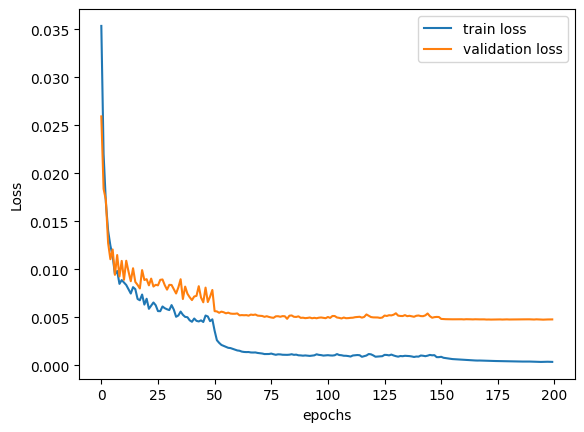

In [10]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(n_epochs), train_losses, label = 'train loss')
plt.plot(torch.arange(n_epochs), val_losses, label = 'validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_graph.png')

This graph represents the model overfitts with training data after few epochs (10-30 epochs).